In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
import IPython.display as display
from IPython.display import HTML
from matplotlib import animation
from itertools import combinations
from matplotlib import rcParams
import time
import sys
rcParams['animation.embed_limit'] = 100

# function to calculate velocities after collision

In [10]:
def compute_new_velocities(v1, v2, r1, r2):
    # Считаем вектор столкновения
    collision_vector = r2 - r1
    collision_unit_vector = collision_vector / np.linalg.norm(collision_vector)
    # Разделяем скорости на нормальную и тангенциальную компоненты
    v1_normal = np.dot(v1, collision_unit_vector) * collision_unit_vector
    v1_tangential = v1 - v1_normal
    v2_normal = np.dot(v2, collision_unit_vector) * collision_unit_vector
    v2_tangential = v2 - v2_normal
    # Обмен нормальными компонентами для абсолютно упругого удара (с одинаковыми массами)
    v1_normal_new = v2_normal
    v2_normal_new = v1_normal
    # Скорости после столкновения
    v1_new = v1_tangential + v1_normal_new
    v2_new = v2_tangential + v2_normal_new
    return v1_new, v2_new


# function for calculation distance between molecules

In [11]:
def count_dists_for_pairs(cords, ids_pairs):
    x_squares = (cords[0][ids_pairs[:,0]] - cords[0][ids_pairs[:,1]])**2
    y_squares = (cords[1][ids_pairs[:,0]] - cords[1][ids_pairs[:,1]])**2
    dists = np.sqrt(x_squares + y_squares)
    return dists

In [12]:
def get_module_vel_distribution(vs, i):
    return np.sqrt(vs[i][0]**2 + vs[i][1]**2)

In [13]:
n_particles_approx = 1200
radius = 0.005

In [14]:
boundary_dist = radius * 2

In [15]:
cords = np.random.random((2,n_particles_approx))

In [16]:
def delete_colliding_particles(cords):
    ids_approx = np.arange(len(cords[0]))
    ids_pairs_approx = np.asarray(list(combinations(ids_approx,2)))
    colliding_pairs = ids_pairs_approx[count_dists_for_pairs(cords, ids_pairs_approx) < boundary_dist]
    particles_to_delete_ind = colliding_pairs[:,0]
    cords_x = np.delete(cords[0], particles_to_delete_ind)
    cords_y = np.delete(cords[1], particles_to_delete_ind)
    return np.array([cords_x,cords_y])
cords = delete_colliding_particles(cords)


In [17]:
n_particles = len(cords[0])
ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids,2)))

generating initial velocities and coordinates 

In [18]:
print(len(ids_pairs[count_dists_for_pairs(cords, ids_pairs) < boundary_dist]))
print(n_particles)

0
1003


In [19]:
mean = 1
std_dev = np.sqrt(0.2)
v = np.random.random((2, n_particles)) * 4 -1   # начальное распредление скоростей

v_initial = v.copy()
v_initial_modules = np.sqrt(v_initial[0]**2 + v_initial[1]**2)

In [20]:
v_sq_mid = (v[0]**2 + v[1]**2).sum(axis = 0) / n_particles

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


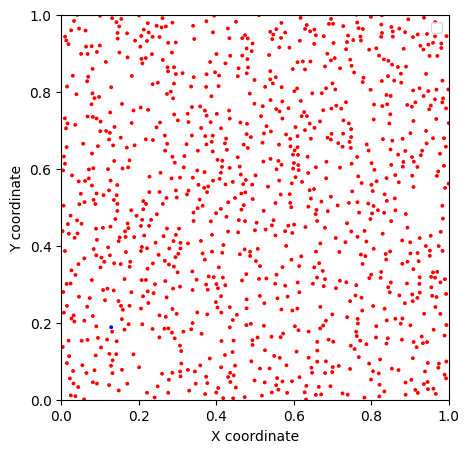

In [21]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
x, y = cords[0][1:], cords[1][1:]
circles = [plt.Circle((xi, yi), radius =radius, linewidth=0) for xi,yi in zip(x,y)]
circle = [plt.Circle((cords[0][0],cords[1][0]), radius = radius, linewidth=0)]
cred = matplotlib.collections.PatchCollection(circles, facecolors='red')
cfast = matplotlib.collections.PatchCollection(circle, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cfast)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
plt.legend()

In [22]:
def motion(cords, v, ts, dt):
    rs = np.zeros((ts, cords.shape[0], cords.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    count_balls_collided = 0
    rs[0] = cords.copy()
    vs[0] = v.copy()
    for i in range(1,ts):
        start_time = time.time()
        pairs_that_collide = ids_pairs[count_dists_for_pairs(cords, ids_pairs) < boundary_dist]
        for pair in pairs_that_collide:
            count_balls_collided += 1
            ind1 = pair[0]
            ind2 = pair[1]
            v1, v2  = np.array([v[0][ind1], v[1][ind1]]), np.array([v[0][ind2], v[1][ind2]])
            r1, r2 = np.array([cords[0][ind1], cords[1][ind1]]), np.array([cords[0][ind2], cords[1][ind2]])
            v1_new, v2_new = compute_new_velocities(v1, v2, r1, r2)
            v[0][ind1] = v1_new[0]
            v[1][ind1] = v1_new[1]
            v[0][ind2] = v2_new[0]
            v[1][ind2] = v2_new[1]
        v[0,cords[0]>1] = -v[0, cords[0]>1]
        v[0,cords[0]<0] = np.abs(v[0, cords[0]<0])
        v[1,cords[1]>1] = -np.abs(v[1,cords[1]>1])
        v[1,cords[1]<0] = np.abs(v[1,cords[1]<0])
        
        cords = cords + v * dt
        rs[i] = cords.copy()
        vs[i] = v.copy()
        elapsed_time = time.time() - start_time
        sys.stdout.write(f"\rFrame {i}/{ts} took {elapsed_time:.4f} seconds")
        sys.stdout.flush()
    return rs, vs, count_balls_collided

In [23]:
# radius = 0.005
ts = 300
dt = 0.001
rs, vs, ball_colided_num = motion(cords, v, ts, dt)
ball_colided_num

Frame 17/300 took 0.0329 seconds

Frame 299/300 took 0.0383 seconds

30902

MovieWriter Pillow unavailable; using Pillow instead.


Frame 0/300 took 0.4181 seconds

/var/folders/nb/1l3qtmxx0d58s33_w51ngqk00000gn/T/ipykernel_17874/979528110.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Frame 99/300 took 0.1890 seconds 
 till the end of cumputation approximately 543.4682 seconds
Frame 299/300 took 0.1730 secondsanimation calc finished, saving
Frame 0/300 took 0.2326 seconds

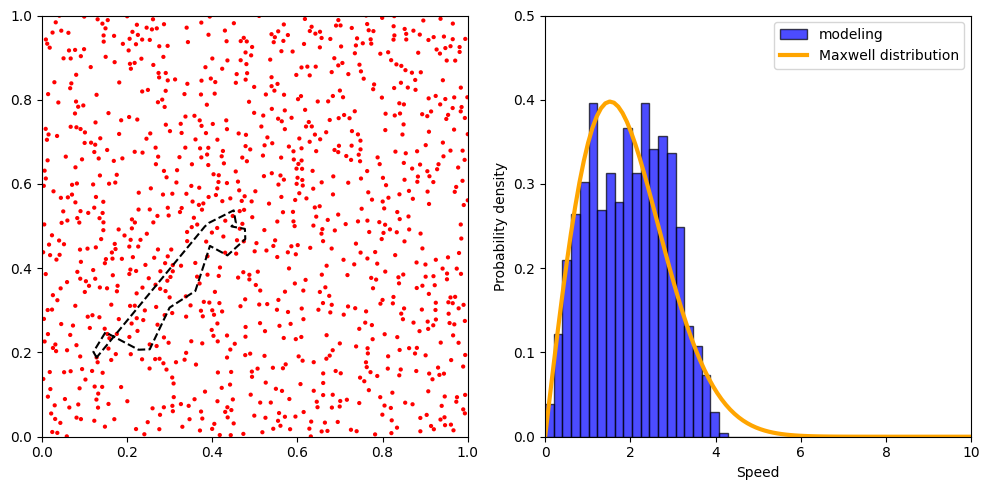

In [24]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5))
trajectory_x = []
trajectory_y = []
s = np.linspace(0,10,100)
a = 2 / v_sq_mid
p = a * s * np.exp(-s**2 * a / 2)
start_time_overall = time.time()
def animate(i):
 
    start_time = time.time()
  
    ax.clear()
    ax1.clear()
    x, y = rs[i][0], rs[i][1]
    circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(x,y)]
    cred = matplotlib.collections.PatchCollection(circles, facecolors='red')
    ax.add_collection(cred)
    trajectory_x.append(rs[i][0][0])
    trajectory_y.append(rs[i][1][0])
    ax.plot(trajectory_x, trajectory_y, color='black', linestyle='--', linewidth=1.5, label='Trajectory')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    v_mods = get_module_vel_distribution(vs, i)

    ax1.hist(v_mods, bins=np.linspace(0, 10, 50), color='blue', edgecolor='black', alpha=0.7, label = 'modeling', density=True)
    ax1.set_xlabel('Speed')
    ax1.set_ylabel('Probability density')
    ax1.plot(s,p,color = 'orange',linewidth = 3, label = 'Maxwell distribution')
    ax1.set_ylim(0,0.5)
    ax1.set_xlim(0,10)
    ax1.legend()

    elapsed_time = time.time() - start_time
    if i == 100:
        time_for_100 = time.time() - start_time_overall
        time_till_end =  time_for_100 / 100 * 1000 - 100
        print(f' \n till the end of cumputation approximately {time_till_end:.4f} seconds')
    sys.stdout.write(f"\rFrame {i}/{len(rs)} took {elapsed_time:.4f} seconds")
    sys.stdout.flush()

    plt.tight_layout()
    
    

ani = animation.FuncAnimation(fig, animate, frames= len(rs), interval=33, repeat = False)
ani.save('gas_sim.gif',writer="Pillow",fps=30)
print('animation calc finished, saving')

$$ kTN = <E_{kin}> = \dfrac{m \cdot <v^2>}{2} $$

$ <v^2> $ const cause E = const

$ \dfrac{m}{kT} = \dfrac{2}{<v^2>} $

$ p(v) = \frac{m}{kT} v e^{-\frac{mv^2}{2kT}} = \dfrac{2}{<v^2>} v e^{-\frac{v^2}{<v^2>}}$


In [25]:
print('do:', v_sq_mid)

do: 4.647388965026307


In [26]:
x = np.linspace(0,10,100)
a = 2 / v_sq_mid
p = a * x * np.exp(-x**2 * a / 2)

In [27]:
v_fin = vs[-1]
v_module_distribution_last = np.sqrt(v_fin[0]**2 + v_fin[1]**2)


Text(0.5, 1.0, 'Number of collisions: 30902')

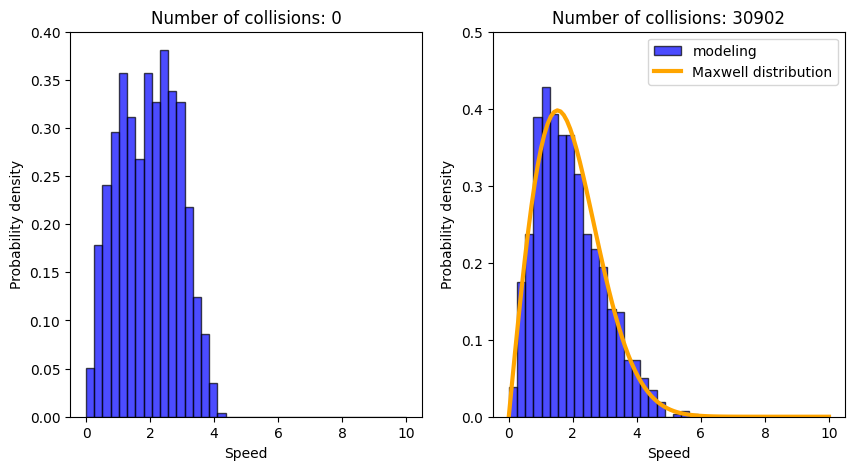

In [28]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5))
bins = np.linspace(0,10,40)

ax1.hist(v_module_distribution_last, bins=bins, color='blue', edgecolor='black', alpha=0.7, label = 'modeling', density=True)
ax1.set_xlabel('Speed')
ax1.set_ylabel('Probability density')
ax1.plot(x,p,color = 'orange',linewidth = 3, label = 'Maxwell distribution')
ax1.set_ylim(0,0.5)
ax1.legend()
ax.hist(v_initial_modules, bins=bins, color='blue', edgecolor='black', alpha=0.7, label = 'modeling', density=True)
ax.set_xlabel('Speed')
ax.set_ylabel('Probability density')
ax.set_title('Number of collisions: 0')
ax1.set_title(f'Number of collisions: {ball_colided_num}')